In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, MegaForSequenceClassification
import torchinfo
torch.__version__

/Users/alan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


'2.3.0'

In [2]:
device = torch.device("cpu")
device

device(type='cpu')

In [3]:
tokenizer = AutoTokenizer.from_pretrained("mnaylor/mega-base-wikitext")
model = MegaForSequenceClassification.from_pretrained("mnaylor/mega-base-wikitext")
model.classifier.out_proj = torch.nn.Linear(in_features=128, out_features=3, bias=True)
model.to(device)

Some weights of MegaForSequenceClassification were not initialized from the model checkpoint at mnaylor/mega-base-wikitext and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MegaForSequenceClassification(
  (mega): MegaModel(
    (embedding_layer): MegaEmbeddings(
      (word_embeddings): Embedding(50265, 128, padding_idx=1)
    )
    (layers): ModuleList(
      (0-3): 4 x MegaBlock(
        (mega_layer): MegaMovingAverageGatedAttention(
          (activation): SiLU()
          (dropout): MegaDropout()
          (hidden_dropout): MegaDropout()
          (attention_dropout): MegaDropout()
          (norm): MegaSequenceNorm(
            (norm): MegaScaleNorm()
          )
          (ema_gate): MegaMultiDimensionDampedEma()
          (v_proj): Linear(in_features=128, out_features=256, bias=True)
          (mx_proj): Linear(in_features=128, out_features=576, bias=True)
          (h_proj): Linear(in_features=256, out_features=128, bias=True)
          (rel_pos_bias): MegaRotaryRelativePositionalBias()
          (softmax): Softmax(dim=-1)
        )
        (nffn): MegaNormalizedFeedForwardNetwork(
          (activation): SiLU()
          (dropout): MegaDropout()

In [4]:
torchinfo.summary(model)

Layer (type:depth-idx)                                            Param #
MegaForSequenceClassification                                     --
├─MegaModel: 1-1                                                  --
│    └─MegaEmbeddings: 2-1                                        --
│    │    └─Embedding: 3-1                                        6,433,920
│    └─ModuleList: 2-2                                            --
│    │    └─MegaBlock: 3-2                                        223,042
│    │    └─MegaBlock: 3-3                                        223,042
│    │    └─MegaBlock: 3-4                                        223,042
│    │    └─MegaBlock: 3-5                                        223,042
├─MegaClassificationHead: 1-2                                     --
│    └─Linear: 2-3                                                16,512
│    └─Dropout: 2-4                                               --
│    └─Linear: 2-5                                                3

In [5]:
tokenizer

RobertaTokenizerFast(name_or_path='mnaylor/mega-base-wikitext', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

In [6]:
data_check_test = load_dataset(
    "csv", data_files="data/tweets.csv"
    )
print(data_check_test['train'][0])

def preprocess_function(examples):
    # Add your binary labels based on the 'class' column
    examples['hate_speech'] = 1 if examples['class'] == 0 else 0
    examples['offensive_language'] = 1 if examples['class'] == 1 else 0
    examples['neither'] = 1 if examples['class'] == 2 else 0
    return examples

data_check_test = data_check_test.map(preprocess_function)
print(data_check_test['train'][0])
# Dataset only have training data, hence split it into train/test
data_check_test = data_check_test['train'].train_test_split(test_size=0.25)

{'idx': 0, 'count': 3, 'hate_speech': 0, 'offensive_language': 0, 'neither': 3, 'class': 2, 'tweet': "!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."}
{'idx': 0, 'count': 3, 'hate_speech': 0, 'offensive_language': 0, 'neither': 1, 'class': 2, 'tweet': "!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."}


In [7]:
def tokenize_func(examples):
    #  padding: 'max_length': pad to a length specified by the max_length argument or the
    #  maximum length accepted by the model if no max_length is provided (max_length=None).
    #  Padding will still be applied if you only provide a single sequence. [from documentation]


    #  truncation: True or 'longest_first': truncate to a maximum length specified
    #  by the max_length argument or the maximum length accepted by the model if
    #  no max_length is provided (max_length=None). This will truncate token by
    #  token, removing a token from the longest sequence in the pair until the
    #  proper length is reached. [from documentation]
    return tokenizer(
        examples["tweet"], padding="max_length", truncation=True
        )

In [8]:
tokenized_data = data_check_test.map(tokenize_func, batched=True)


Map:   0%|          | 0/18587 [00:00<?, ? examples/s]

Map:   0%|          | 0/6196 [00:00<?, ? examples/s]

In [9]:
print(tokenized_data)
tokenized_data = tokenized_data.remove_columns([
    "idx", "count", "tweet", "hate_speech", "offensive_language", "neither"])
print(tokenized_data['train'][0])
tokenized_data.set_format("torch")

DatasetDict({
    train: Dataset({
        features: ['idx', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet', 'input_ids', 'attention_mask'],
        num_rows: 18587
    })
    test: Dataset({
        features: ['idx', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet', 'input_ids', 'attention_mask'],
        num_rows: 6196
    })
})
{'class': 1, 'input_ids': [0, 13963, 787, 267, 7381, 627, 2977, 415, 35, 13932, 127, 42104, 8, 303, 24, 11, 110, 34333, 42167, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [10]:
train_dataloader = DataLoader(tokenized_data['train'], batch_size=8)
test_dataloader = DataLoader(tokenized_data['test'], batch_size=8)

dataiter = iter(test_dataloader)
batch_data= next(dataiter)

print(batch_data.keys())

dict_keys(['class', 'input_ids', 'attention_mask'])


In [13]:
from transformers import get_scheduler
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 50
num_training_steps = num_epochs * len(train_dataloader)
# feel free to experiment with different num_warmup_steps
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=1, num_training_steps=num_training_steps
)

In [14]:
import evaluate
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()

criterion = torch.nn.CrossEntropyLoss()

model.mega.requires_grad_(False)

epoch_loss = []

for epoch in range(num_epochs):
    for batch in train_dataloader:
        input = batch["input_ids"]
        mask = batch["attention_mask"]
        output = batch["class"]
        
        outputs = model(input, mask)
        with torch.no_grad():
            _, preds = torch.max(outputs.logits, 1)
        loss = criterion(outputs.logits, output)

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        logits = outputs.logits

        progress_bar.update(1)
    epoch_loss.append(loss)
    print(epoch_loss)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/116200 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
metric = evaluate.load("accuracy")
progress_bar = tqdm(range(len(test_dataloader)))
model.eval()

perf = np.zeros([3,3])
num_epochs = 2


for batch in test_dataloader:
    input = batch["input_ids"]
    mask = batch["attention_mask"]
    output = batch["class"]
    
    with torch.no_grad():
        outputs = model(input, mask)

    logits = outputs.logits

    _, preds = torch.max(outputs.logits, 1)
    metric.add_batch(predictions=preds, references=output)
    progress_bar.update(1)

metric.compute()

  0%|          | 0/775 [00:00<?, ?it/s]

KeyboardInterrupt: 

## FINE TUNE

In [20]:
from tqdm.auto import tqdm
import evaluate
import matplotlib.pyplot as plt
from transformers import get_scheduler
from torch.optim import AdamW

def train_epoch(model, train_dataloader, optimizer, lr_scheduler):
    progress_bar = tqdm(range(len(train_dataloader)))
    metric = evaluate.load("accuracy")
    model.mega.requires_grad_(False)
    model.train()
    criterion = torch.nn.CrossEntropyLoss()

    epoch_loss = 0
    for batch in train_dataloader:
        input = batch["input_ids"]
        mask = batch["attention_mask"]
        y = batch["class"]

        outputs = model(input, attention_mask=mask)

        with torch.no_grad():
            _, preds = torch.max(outputs.logits, 1)

        loss = criterion(outputs.logits, y)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        
        metric.add_batch(predictions=preds, references=y)

        epoch_loss += loss.item()
        progress_bar.update(1)
    lr_scheduler.step()
    epoch_loss /= len(test_dataloader)
    accuracy = metric.compute()['accuracy']

    return epoch_loss, accuracy

def eval(model, test_dataloader):
    progress_bar = tqdm(range(len(test_dataloader)))
    metric = evaluate.load("accuracy")
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()

    epoch_loss = 0
    for batch in test_dataloader:
        input = batch["input_ids"]
        mask = batch["attention_mask"]
        y = batch["class"]
        
        with torch.no_grad():
            outputs = model(input, attention_mask=mask)

        logits = outputs.logits
        loss = criterion(outputs.logits, y)

        predictions = torch.argmax(logits, dim=-1)

        metric.add_batch(predictions=predictions, references=y)

        epoch_loss += loss.item()
        progress_bar.update(1)

    epoch_loss /= len(test_dataloader)
    accuracy = metric.compute()['accuracy']
    
    return epoch_loss, accuracy

def train(model,
          train_dataloader,
          test_dataloader,
          num_epochs=2,
          learning_rate=5e-5,
          patience=2):

    # count epochs where the model didn't improve
    counter = 0
    best_val_acc = 0
    best_epoch = 0
    best_model = None

    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # feel free to experiment with different num_warmup_steps
    lr_scheduler = get_scheduler(
        name="linear", optimizer=optimizer, num_warmup_steps=1, num_training_steps=num_epochs*len(train_dataloader)
    )
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(
            model, train_dataloader, optimizer, lr_scheduler)
        val_loss, val_acc = eval(model, test_dataloader)

        print(f"Epoch {epoch+1} accuracy: train={train_acc:.3f}, test={val_acc:.3f}")

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # early stopping
        # TODO: check if val_acc <= best_val_acc + some minimum increase
        if val_acc <= best_val_acc + 1e-4:
            counter += 1
            if counter >= patience:
                break
        else:
            best_val_acc = val_acc
            counter = 0
            best_epoch = epoch
            best_model = model.state_dict()

    return train_accuracies, val_accuracies, train_losses, val_losses, best_epoch, best_model

train_acc, val_acc, train_losses, val_losses, best_epoch, best_model = train(model, train_dataloader, test_dataloader, num_epochs=5, learning_rate=5e-5)

  0%|          | 0/2324 [00:00<?, ?it/s]

  0%|          | 0/775 [00:00<?, ?it/s]

Epoch 1 accuracy: train=0.774, test=0.773


  0%|          | 0/2324 [00:00<?, ?it/s]

  0%|          | 0/775 [00:00<?, ?it/s]

Epoch 2 accuracy: train=0.775, test=0.773


  0%|          | 0/2324 [00:00<?, ?it/s]

  0%|          | 0/775 [00:00<?, ?it/s]

Epoch 3 accuracy: train=0.775, test=0.773


  0%|          | 0/2324 [00:00<?, ?it/s]

  0%|          | 0/775 [00:00<?, ?it/s]

Epoch 4 accuracy: train=0.775, test=0.773


  0%|          | 0/2324 [00:00<?, ?it/s]

KeyboardInterrupt: 

NameError: name 'train_losses' is not defined

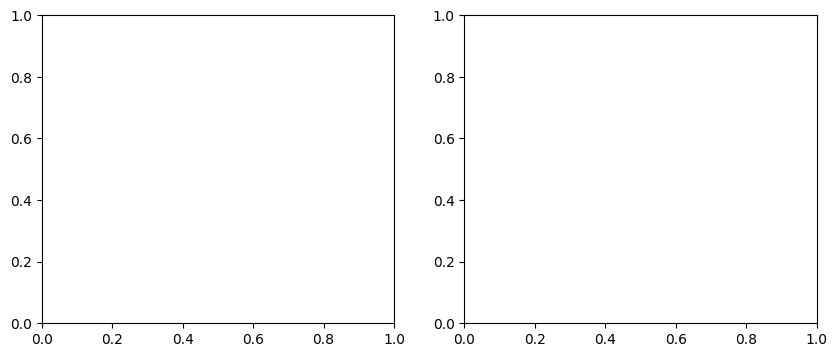

In [21]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
epoch_axis = range(1, len(train_losses)+1)
ax[0].plot(epoch_axis, train_losses, label='train')
ax[0].plot(epoch_axis, val_losses, label='val')
ax[0].axvline(best_epoch+1, label='best')

ax[1].plot(epoch_axis, train_acc, label='train')
ax[1].plot(epoch_axis, val_acc, label='val')
ax[1].axvline(best_epoch+1, label='best')
plt.legend()
plt.show()